In [122]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from scipy.signal import hann
from scipy.ndimage import gaussian_filter
from scipy.ndimage import zoom
from skimage.io import imread
from skimage.transform import resize

from sklearn.model_selection import train_test_split
import cv2
import io
from PIL import Image
import base64

model = load_model("model.keras")

def imageToBytes(img):
    image = Image.fromarray((img*255).astype(np.uint8) )
    image_bytes = io.BytesIO()
    image.save(image_bytes, format="PNG")
    image_bytes = image_bytes.getvalue()
    return image_bytes

def bytesToImage(bytes_img):
    image = Image.open(io.BytesIO(bytes_img))
    image_array = np.array(image).astype(np.float32)/255
    return image_array

def process_bytes(bytes_img):
    image_array_rgb = bytesToImage(bytes_img)
    image_array_rgb  = denoiser.denoise_image( image_array_rgb  , iteration=1)
    return imageToBytes(image_array_rgb )

def encode_image(image_bytes):
    return base64.b64encode(image_bytes).decode('utf-8')


def denoise_chunks(chunks, model):
    denoised_chunks = model.predict(chunks, verbose=0)
    denoised_chunks = np.clip(0, 1, denoised_chunks)
    return denoised_chunks

def image_to_chunks(input_image, chunk_size, overlap):
    # Get the dimensions of the input image
    height, width, channels = input_image.shape

    # Create a list to store chunks
    chunks = []

    # Calculate the step size for overlapping chunks
    step = chunk_size - overlap

    for y in range(0, height, step):
        for x in range(0, width, step):
            # Extract a chunk from the input image
            chunk = input_image[y:y+chunk_size, x:x+chunk_size].copy()

            # Check if the chunk size is less than 64x64 and pad it with zeros if needed
            if chunk.shape[0] < chunk_size or chunk.shape[1] < chunk_size:
                padded_chunk = np.zeros((chunk_size, chunk_size, channels), dtype=np.uint8)
                padded_chunk[:chunk.shape[0], :chunk.shape[1]] = chunk
                chunk = padded_chunk

            chunks.append(chunk)

    return np.array(chunks) 

def chunks_to_image(denoised_chunks, input_image, chunk_size, overlap):
    # Get the dimensions of the input image
    height, width, channels = input_image.shape



    # Reconstruct the denoised image
    output_image = np.zeros((height + (chunk_size- height//chunk_size) + overlap, width+ (chunk_size-width//chunk_size) + overlap, 3), dtype=np.float32)
    index = 0

    # Calculate the step size for overlapping chunks
    step = chunk_size - overlap

    for y in range(0, height, step):
        for x in range(0, width, step):

            chunk = denoised_chunks[index]

            # Apply Hanning window to the chunk during reconstruction for each channel
            hann_window = hann(chunk_size)
            for c in range(channels):
                chunk[:, :, c] = (chunk[:, :, c].astype(np.float32)) * hann_window[:, np.newaxis] * hann_window[np.newaxis, :]

            output_image[y:y+chunk_size, x:x+chunk_size, :] += chunk
            index += 1
    
    return output_image[0:input_image.shape[0],0:input_image.shape[1]]

def blurArray(image_array,sigma = 1.0):
    import cv2
    import numpy as np


    # Split the image into channels (BGR order in OpenCV)
    blue_channel, green_channel, red_channel = cv2.split(image_array)

    # Apply Gaussian blur to each channel independently
    kernel_size = (5, 5)  # Adjust the kernel size as needed
    blue_blurred = cv2.GaussianBlur(blue_channel, kernel_size, sigma)
    green_blurred = cv2.GaussianBlur(green_channel, kernel_size, sigma)
    red_blurred = cv2.GaussianBlur(red_channel, kernel_size, sigma)

    # Merge the blurred channels back into a color image
    blurred_image = cv2.merge((blue_blurred, green_blurred, red_blurred))

    return blurred_image

def denoise_image(input_image, iteration=1, ratio = 1):

    #Extracting chunks
    chunk_size = 128
    overlap = chunk_size//2

    width , height, channels = input_image.shape

    temp_image  = cv2.resize(input_image, ( int(height*ratio),int(width*ratio), ), interpolation=cv2.INTER_CUBIC)

    for i in range(iteration):

        padded_image =  np.pad(temp_image.astype(np.float32), [(chunk_size,chunk_size), (chunk_size,chunk_size), (0,0)], mode='constant')
        chunks = image_to_chunks(padded_image , chunk_size=chunk_size , overlap=overlap)
        chunks = denoise_chunks(chunks, model)
        padded_image = chunks_to_image(chunks, padded_image , chunk_size=chunk_size , overlap=overlap)
        temp_image = padded_image[chunk_size:-chunk_size,chunk_size:-chunk_size ]
        # post process correction

        

    output_image= cv2.resize( temp_image , ( height, width), interpolation=cv2.INTER_CUBIC)


    return output_image

In [123]:
def imageToBytes(img):
    image = Image.fromarray((img*255).astype(np.uint8) )
    image_bytes = io.BytesIO()
    image.save(image_bytes, format="PNG")
    image_bytes = image_bytes.getvalue()
    return image_bytes

def bytesToImage(bytes_img):
    image = Image.open(io.BytesIO(bytes_img))
    image_array = np.array(image).astype(np.float32)/255
    return image_array


In [139]:
## Memory cleaner

import gc


gc.collect() 

3491

C:\Users\kibio\AppData\Local\Temp\ipykernel_5828\3661541316.py:88: DeprecationWarning: Importing hann from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hann' or the convenience function 'scipy.signal.get_window' instead.
  hann_window = hann(chunk_size)


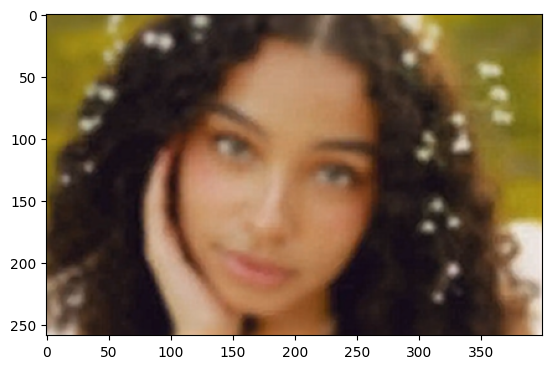

In [152]:
img = load_and_preprocess_image("girl.png")

denoise_image(img,iteration=2 ,ratio = 1) 
plt.imshow(predicted )

In [34]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
def load_and_preprocess_image(filename):
    img = imread(filename, as_gray=False)
    img = resize(img, (img.shape[0],img.shape[1],3)) 
    return img